In [8]:
import pandas as pd
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='dark')
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

## 预测利润

In [2]:
df = pd.read_csv('ex1data1.txt', names = ['population','profit'])

In [100]:
df.head(7)

,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233
5,8.3829,11.8860
6,7.4764,4.3483


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 2 columns):
population    97 non-null float64
profit        97 non-null float64
dtypes: float64(2)
memory usage: 1.6 KB


C:\Users\Administrator\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


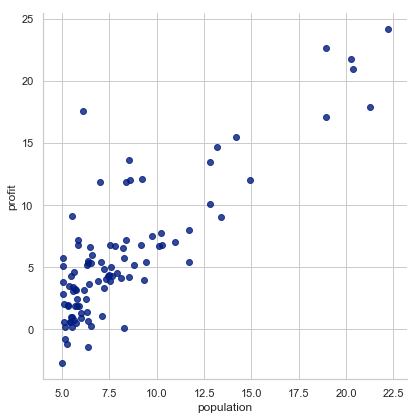

In [9]:
sns.lmplot('population', 'profit', df, size=6, fit_reg=False)
plt.show()

### 数据处理

In [96]:
# 读取特征
def get_X(df):
    ones = pd.DataFrame({'ones': np.ones(len(df))})
    # 根据列合并数据
    data = pd.concat([ones, df], axis=1)
    # 返回ndarray，不是矩阵
    return data.iloc[:,:-1].values

In [71]:
# 读取标签
def get_Y(df):
    return np.array(df.iloc[:,-1])

> 特征缩放
$$ x_{n}=\dfrac {x_{n}-u_{n}}{s_{n}} $$

In [90]:
# 特征缩放
def normalize_feature(df):
    return df.apply(lambda column: (column - column.mean()) / column.std())

> 多变量的假设 h 表示为：\\[{{h}_{\theta }}\left( x \right)={{\theta }_{0}}+{{\theta }_{1}}{{x}_{1}}+{{\theta }_{2}}{{x}_{2}}+...+{{\theta }_{n}}{{x}_{n}}\\] 
这个公式中有n+1个参数和n个变量，为了使得公式能够简化一些，引入${{x}_{0}}=1$， 
此时模型中的参数是一个n+1维的向量，任何一个训练实例也都是n+1维的向量，特征矩阵X的维度是 m*(n+1)。 因此公式可以简化为：${{h}_{\theta }}\left( x \right)={{\theta }^{T}}X$，其中上标T代表矩阵转置。


> 代价函数
$$J\left( \theta  \right)=\frac{1}{2m}\sum\limits_{i=1}^{m}{{{\left( {{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}} \right)}^{2}}}$$
其中：\\[{{h}_{\theta }}\left( x \right)={{\theta }^{T}}X={{\theta }_{0}}{{x}_{0}}+{{\theta }_{1}}{{x}_{1}}+{{\theta }_{2}}{{x}_{2}}+...+{{\theta }_{n}}{{x}_{n}}\\] 

In [168]:
def linear_regression(X_data, y_data, alpha, epoch, optimizer=tf.train.GradientDescentOptimizer):
      # placeholder for graph input
    X = tf.placeholder(tf.float32, shape=X_data.shape)
    y = tf.placeholder(tf.float32, shape=y_data.shape)
    

    # construct the graph
    with tf.variable_scope('linear-regression'):
        W = tf.get_variable("weights",
                            (X_data.shape[1], 1),
                            initializer=tf.constant_initializer())  # n*1
        tf.get_variable_scope().reuse_variables()

        y_pred = tf.matmul(X, W)  # m*n @ n*1 -> m*1

        loss = 1 / (2 * len(X_data)) * tf.matmul((y_pred - y), (y_pred - y), transpose_a=True)  

    opt = optimizer(learning_rate=alpha)
    opt_operation = opt.minimize(loss)

    # run the session
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        loss_data = []

        for i in range(epoch):
            _, loss_val, W_val = sess.run([opt_operation, loss, W], feed_dict={X: X_data, y: y_data})
            loss_data.append(loss_val[0, 0])  # because every loss_val is 1*1 ndarray

            if len(loss_data) > 1 and np.abs(loss_data[-1] - loss_data[-2]) < 10 ** -9:  
                # print('Converged at epoch {}'.format(i))
                break

    # clear the graph
    tf.reset_default_graph()
    return {'loss': loss_data, 'parameters': W_val}  # just want to return in row vector format

In [99]:
X = get_X(df)
print(X.shape, type(X))
Y = get_Y(df)
print(Y.shape, type(Y))

(97, 2) <class 'numpy.ndarray'>
(97,) <class 'numpy.ndarray'>


In [101]:
# 特征数
theta = np.zeros(X.shape[1])
theta

array([0., 0.])

In [102]:
# linear regression cost
def lr_cost(theta, X, Y):
    m = X.shape[0]  # 样本数
    y_pred = X @ theta
    inner = y_pred - Y  
    square_sum = inner.T @ inner  # 相当于 np.sum(np.square(a, b))
    cost = square_sum / (2 * m)
    return cost

In [103]:
lr_cost(theta, X, Y)

32.072733877455676

### 批量梯度下降 -- batch gradient decent
$${{\theta }_{j}}:={{\theta }_{j}}-\alpha \frac{\partial }{\partial {{\theta }_{j}}}J\left( \theta  \right)$$

In [104]:
def gradient(theta, X, Y):
    m = X.shape[0]
    inner = X.T @ (X @ theta - Y)
    return inner / m

In [105]:
def batch_gradient_decent(theta, X, Y, epoch, alpha = 0.01):
    cost_data = [lr_cost(theta, X, Y)]
    theta_ = theta.copy()
    
    for _ in range(epoch):
        theta_ = theta_ - alpha * gradient(theta_, X, Y)
        cost_data.append(lr_cost(theta_, X, Y))
        
    return theta_, cost_data

In [106]:
epoch = 500
final_theta, cost_data = batch_gradient_decent(theta, X, Y, epoch)

In [ ]:
final_theta, cost_data

In [108]:
lr_cost(final_theta, X, Y)

4.713809531116866

### 数据可视化

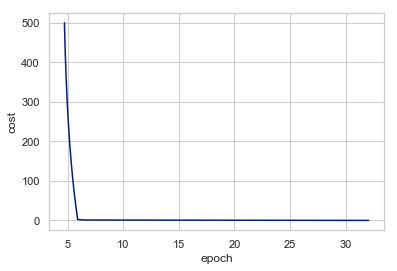

In [118]:
ax = sns.lineplot(x=cost_data, y=np.arange(epoch+1))
ax.set_xlabel('epoch')
ax.set_ylabel('cost')
plt.show()

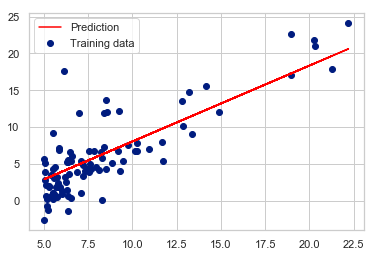

In [121]:
b = final_theta[0]
k = final_theta[1]
plt.scatter(df.population, df.profit, label='Training data')
plt.plot(df.population, df.population * k + b, label='Prediction', color='red')
plt.legend(loc=2)
plt.show()

## 预测房价

In [122]:
df2 = pd.read_csv('ex1data2.txt', names=['square', 'bedrooms', 'price'])
df2.head()

,square,bedrooms,price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


In [126]:
data2 = normalize_feature(df2)
data2.head()

,square,bedrooms,price
0,0.130010,-0.223675,0.475747
1,-0.504190,-0.223675,-0.084074
2,0.502476,-0.223675,0.228626
3,-0.735723,-1.537767,-0.867025
4,1.257476,1.090417,1.595389


### 多变量批量梯度下降 -- multi-var batch gradient decent

In [127]:
X2 = get_X(data2)
print(X2.shape, type(X2))
Y2 = get_Y(data2)
print(Y2.shape, type(Y2))

(47, 3) <class 'numpy.ndarray'>
(47,) <class 'numpy.ndarray'>


In [128]:
alpha2 = .01
theta2 = np.zeros(X2.shape[1])
epoch = 500
final_theta_2, cost_data_2 = batch_gradient_decent(theta2, X2, Y2, epoch, alpha=alpha2)

In [144]:
final_theta_2

array([-1.20848957e-16,  8.30383883e-01,  8.23982853e-04])

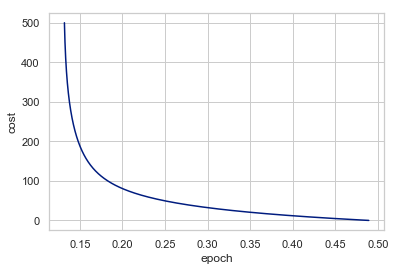

In [129]:
ax = sns.lineplot(x=cost_data_2, y=np.arange(epoch+1))
ax.set_xlabel('epoch')
ax.set_ylabel('cost')
plt.show()

### 学习速率

In [130]:
base = np.logspace(-1, -5, num=4)
candidate = np.sort(np.concatenate((base, base*3)))
candidate

array([1.00000000e-05, 3.00000000e-05, 2.15443469e-04, 6.46330407e-04,
       4.64158883e-03, 1.39247665e-02, 1.00000000e-01, 3.00000000e-01])

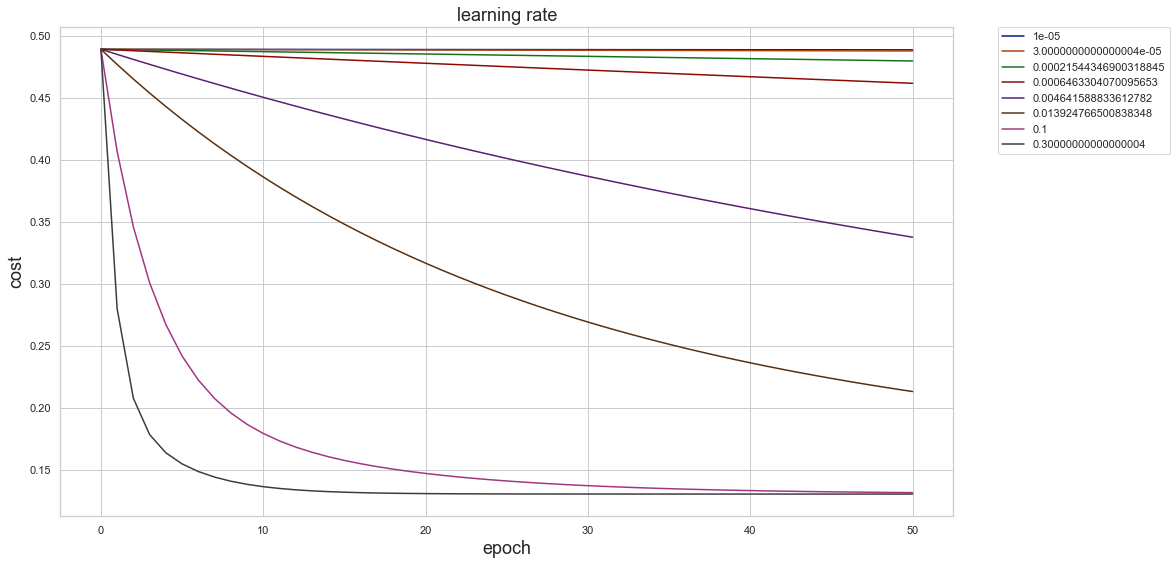

In [142]:
epoch = 50
fig, ax = plt.subplots(figsize=(16, 9))

for alpha in candidate:
    _, cost_data = batch_gradient_decent(theta2, X2, Y2, epoch, alpha=alpha)
    ax.plot(np.arange(epoch+1), cost_data, label=alpha)
    
ax.set_xlabel('epoch', fontsize=18)
ax.set_ylabel('cost', fontsize=18)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('learning rate', fontsize=18)
plt.show()

### 正规方程
正规方程是通过求解下面的方程来找出使得代价函数最小的参数的：$\frac{\partial }{\partial {{\theta }_{j}}}J\left( {{\theta }_{j}} \right)=0$ 。
 假设我们的训练集特征矩阵为 X（包含了${{x}_{0}}=1$）并且我们的训练集结果为向量 y，则利用正规方程解出向量 $\theta ={{\left( {{X}^{T}}X \right)}^{-1}}{{X}^{T}}y$ 。
上标T代表矩阵转置，上标-1 代表矩阵的逆。设矩阵$A={{X}^{T}}X$，则：${{\left( {{X}^{T}}X \right)}^{-1}}={{A}^{-1}}$

梯度下降与正规方程的比较：

梯度下降：需要选择学习率α，需要多次迭代，当特征数量n大时也能较好适用，适用于各种类型的模型	

正规方程：不需要选择学习率α，一次计算得出，需要计算${{\left( {{X}^{T}}X \right)}^{-1}}$，如果特征数量n较大则运算代价大，因为矩阵逆的计算时间复杂度为O(n3)，通常来说当n小于10000 时还是可以接受的，只适用于线性模型，不适合逻辑回归模型等其他模型


### 推导过程
![1](./正规方程推导过程.png)

In [146]:
def normal_equation(X, Y):
    theta = np.linalg.inv(X.T@X)@X.T@Y
    return theta

In [147]:
final_theta_normal = normal_equation(X2, Y2)
final_theta_normal

array([-1.14491749e-16,  8.84765988e-01, -5.31788197e-02])

In [149]:
# 和梯度下降求出的对比
final_theta_2

array([-1.20848957e-16,  8.30383883e-01,  8.23982853e-04])

### Tensorflow多个优化对比
> 需要tensorflow相关知识

In [150]:
X2 = get_X(data2)
print(X2.shape, type(X2))
Y2 = get_Y(data2).reshape(len(X2), 1)
print(Y2.shape, type(Y2))

(47, 3) <class 'numpy.ndarray'>
(47, 1) <class 'numpy.ndarray'>


In [151]:
epoch = 2000
alpha = .01

In [169]:
optimizer_dict = {
    'GO': tf.train.GradientDescentOptimizer,
    'Adagrad': tf.train.AdagradDAOptimizer,
    'Adam': tf.train.AdamOptimizer,
    'Ftrl': tf.train.FtrlOptimizer,
    'RMS': tf.train.RMSPropOptimizer
}
results = []
for name in optimizer_dict:
    res = linear_regression(X2, Y2, alpha, epoch, optimizer=optimizer_dict[name])
    res['name'] = name
    results.append(res)

ValueError: Variable linear-regression/weights does not exist, or was not created with tf.get_variable(). Did you mean to set reuse=tf.AUTO_REUSE in VarScope?

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))

for res in results: 
    loss_data = res['loss']
    
#     print('for optimizer {}'.format(res['name']))
#     print('final parameters\n', res['parameters'])
#     print('final loss={}\n'.format(loss_data[-1]))
    ax.plot(np.arange(len(loss_data)), loss_data, label=res['name'])

ax.set_xlabel('epoch', fontsize=18)
ax.set_ylabel('cost', fontsize=18)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('different optimizer', fontsize=18)
plt.show()